In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

/home/taiger/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import datagen
import utils
from model import RPN

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


(array([9, 9]), array([[0.48430493, 0.6995516 , 0.5515695 , 0.84753364],
        [0.7040359 , 0.58295965, 0.84753364, 0.7264574 ]], dtype=float32))

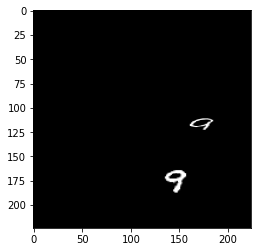

In [3]:
image, gt_cls, gt_boxes = datagen.generate_image(train=True)
gt_boxes = gt_boxes[np.all(gt_boxes >= 0, axis=-1)]  # remove paddings
plt.imshow(image, cmap='gray')
gt_cls, gt_boxes

In [4]:
scales = [8, 16, 32, 64]
ratios = [0.5, 1.0, 2.0]
backbone_shapes = np.array([
    [56, 56],
    [28, 28],
    [14, 14],
    [7, 7],
])
strides = [4, 8, 16, 32]
anchors_per_cell = len(ratios)

In [5]:
anchors = [utils.generate_anchors(scales, ratios, shape, stride, 1)
           for shape, stride in zip(backbone_shapes, strides)]
anchors_per_level = [len(l) for l in anchors]
anchors = np.concatenate(anchors, axis=0)
anchors = utils.norm_boxes(anchors, [RPN.h, RPN.w])
anchors_per_level, sum(anchors_per_level)

([37632, 9408, 2352, 588], 49980)

In [6]:
anchors = utils.generate_all_anchors(scales, ratios, backbone_shapes, strides, 1, [RPN.h, RPN.w])

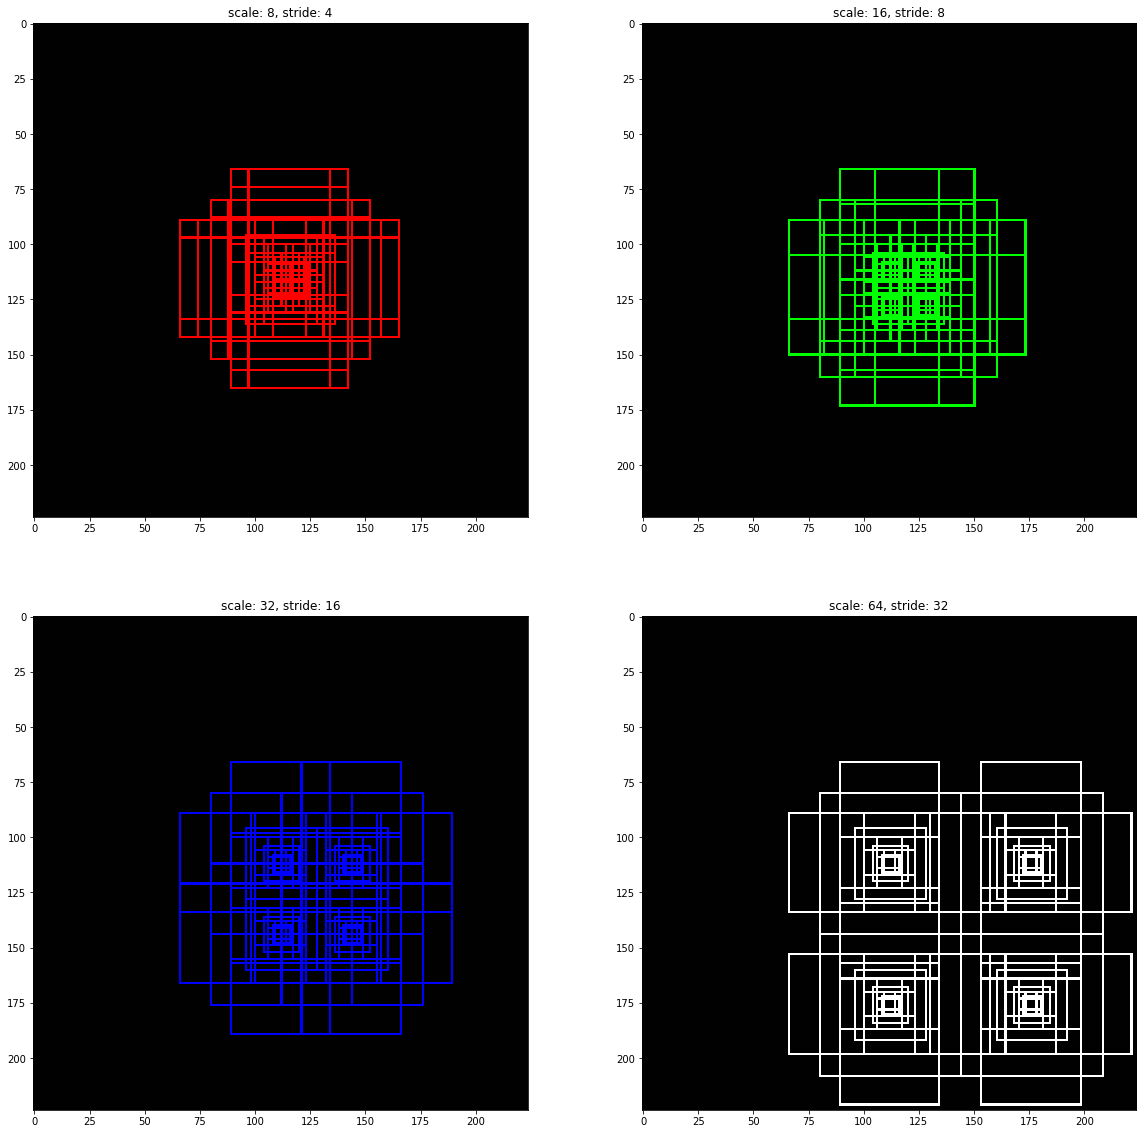

In [7]:
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 255)]

plt.figure(figsize=(20, 20))
for i in range(len(colors)):
    scale, shape, stride, color = scales[i], backbone_shapes[i], strides[i], colors[i]
    tmp_image = np.ones([224, 224, 3], np.uint8)
    tmp_anchors = utils.generate_anchors(scales, ratios, [3, 3], stride, 2)
    for anchor in tmp_anchors:
        y1, x1, y2, x2 = (anchor + 112).astype(np.int64).tolist()
        cv2.rectangle(tmp_image, (x1, y1), (x2, y2), color, 1)
    plt.subplot(2, 2, i+1)
    plt.title(f'scale: {scale}, stride: {stride}')
    plt.imshow(tmp_image)
plt.show()

In [8]:
def compute_ious(anchors, gt_boxes):
    """
        anchors: [N, 4] - (y1, x1, y2, x2)
        gt_boxes: [M, 4] - (y1, x1, y2, x2)
    """
    a_y1, a_x1, a_y2, a_x2 = np.split(anchors, 4, axis=1)  # a_y1 - [N, 1]
    gt_y1, gt_x1, gt_y2, gt_x2 = gt_boxes.T  # gt_y1 - [M,]
    a_area = (a_x2 - a_x1) * (a_y2 - a_y1)
    gt_area = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)

    y1 = np.maximum(a_y1, gt_y1)
    y2 = np.minimum(a_y2, gt_y2)
    x1 = np.maximum(a_x1, gt_x1)
    x2 = np.minimum(a_x2, gt_x2)

    intersection = np.maximum(0., x2 - x1) * np.maximum(0., y2 - y1)
    union = a_area + gt_area - intersection
    return intersection / union

In [9]:
ious = compute_ious(anchors, gt_boxes)
ious.shape

(49980, 2)

In [10]:
max_iou_per_gt_box = np.max(ious, axis=0)
max_iou_per_anchor = np.max(ious, axis=1)
max_iou_per_gt_box.shape, max_iou_per_anchor.shape

((2,), (49980,))

In [11]:
pos1 = np.max(ious, axis=1) >= 0.7
pos2 = np.sum(ious == max_iou_per_gt_box, axis=-1).astype(np.bool)
np.sum(pos1), np.sum(pos2)

(6, 4)

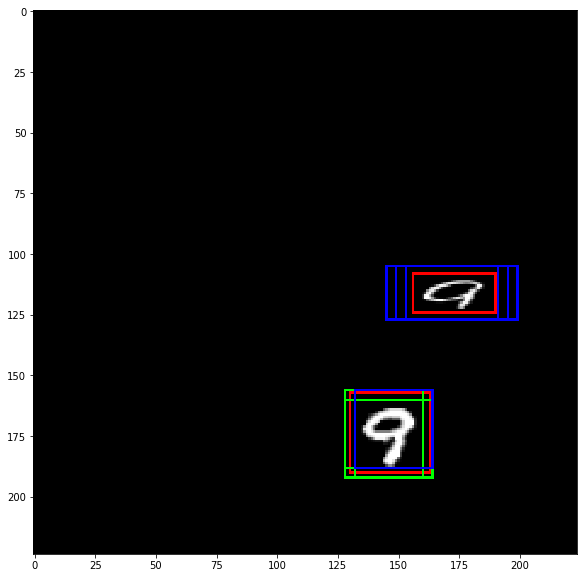

In [12]:
gt_boxes = utils.denorm_boxes(gt_boxes, [RPN.h, RPN.w])
anchors = utils.denorm_boxes(anchors, [RPN.h, RPN.w])

tmp = image.copy()
for box in gt_boxes:  # ground truth boxes
    y1, x1, y2, x2 = box.astype(np.int64).tolist()
    cv2.rectangle(tmp, (x1, y1), (x2, y2), (int(np.max(tmp)), 0, 0), 1)  # red
for anchor in anchors[pos1]:  # ious above threshold
    y1, x1, y2, x2 = anchor.astype(np.int64).tolist()
    cv2.rectangle(tmp, (x1, y1), (x2, y2), (0, int(np.max(tmp)), 0), 1)
for anchor in anchors[pos2]:  # largest iou for each ground truth box
    y1, x1, y2, x2 = anchor.astype(np.int64).tolist()
    cv2.rectangle(tmp, (x1, y1), (x2, y2), (0, 0, int(np.max(tmp))), 1)  # blue
plt.figure(figsize=(10, 10))
plt.imshow(tmp);

In [13]:
np.sum(ious < 0.1), np.sum(pos1 | pos2)  # neg anchors, pos anchors

(97182, 9)